In [ ]:
!pip -q install pandas sqlalchemy bokeh pytest



## 1) Bring the Data into Colab

The ZIP file whice is used and extracted is (`OneDrive_1_7-6-2025.zip`) that contains `train.csv`, `ideal.csv`, and `test.csv`.


In [ ]:

from google.colab import files
import zipfile, os, glob

print("the Uploded zip that contains train.csv, ideal.csv, test.csv")
uploaded = files.upload()

extract_dir = "/content/data"
os.makedirs(extract_dir, exist_ok=True)

zip_name = next(iter(uploaded))
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(extract_dir)

print("Extracted sample:", glob.glob(extract_dir + "/**/*", recursive=True)[:10])


the Uploded zip that contains train.csv, ideal.csv, test.csv


Saving OneDrive_1_7-6-2025.zip to OneDrive_1_7-6-2025 (1).zip
Extracted sample: ['/content/data/ideal.csv', '/content/data/test.csv', '/content/data/train.csv']



## 2) OOP Layer: Exceptions, Datasets (with Inheritance), DB Manager


In [ ]:

class AssignmentError(Exception):
    """Custom error for assignment-specific issues (schema mismatches, X-grid issues, DB failures)."""
    pass


In [ ]:

import pandas as pd
import numpy as np

class BaseDataset:
    """Base loader for CSV datasets with simple validation interface.

    Parameters
    ----------
    path : str
        Filesystem path to the CSV file.
    """
    required_columns: list[str] | None = None

    def __init__(self, path: str):
        self.path = path
        self.df: pd.DataFrame | None = None

    def load(self) -> pd.DataFrame:
        """Read the CSV at `self.path` into a DataFrame."""
        try:
            self.df = pd.read_csv(self.path)
        except FileNotFoundError as e:
            raise AssignmentError(f"File not found: {self.path}") from e
        except Exception as e:
            raise AssignmentError(f"Failed to read CSV: {self.path}") from e
        return self.df

    def validate(self) -> None:
        """Validate the dataset schema. Subclasses may extend this."""
        if self.df is None:
            raise AssignmentError("Call load() before validate().")
        if self.required_columns is not None:
            if list(self.df.columns) != self.required_columns:
                raise AssignmentError(
                    f"{self.__class__.__name__} must have columns {self.required_columns}, "
                    f"found {list(self.df.columns)}"
                )

class TrainingDataset(BaseDataset):
    """Training set with columns: x, y1, y2, y3, y4 (400 rows expected)."""
    required_columns = ["x", "y1", "y2", "y3", "y4"]

class IdealDataset(BaseDataset):
    """Ideal functions set with columns: x, y1..y50 (51 columns total)."""
    def validate(self) -> None:
        if self.df is None:
            raise AssignmentError("Call load() before validate().")
        if self.df.columns[0] != "x" or self.df.shape[1] != 51:
            raise AssignmentError(
                f"IdealDataset must have first column 'x' and total 51 columns (x + y1..y50). "
                f"Found: first={self.df.columns[0]!r}, ncols={self.df.shape[1]}"
            )

class TestDataset(BaseDataset):
    """Test set with columns: x, y (points to be mapped)."""
    required_columns = ["x", "y"]


In [ ]:

from sqlalchemy import create_engine

class DBManager:
    """SQLite helper using SQLAlchemy.

    Parameters
    ----------
    db_path : str
        Path to the SQLite database file (e.g., '/content/results.db').
    """
    def __init__(self, db_path: str):
        self.db_path = db_path
        self.engine = create_engine(f"sqlite:///{db_path}", echo=False)

    def write(self, name: str, df: pd.DataFrame) -> None:
        """Write a DataFrame to SQLite (replace existing table)."""
        try:
            df.to_sql(name, self.engine, if_exists="replace", index=False)
        except Exception as e:
            raise AssignmentError(f"Failed to write table '{name}'") from e

    def read(self, name: str) -> pd.DataFrame:
        """Read a table from SQLite into a DataFrame."""
        try:
            return pd.read_sql_table(name, self.engine)
        except Exception as e:
            raise AssignmentError(f"Failed to read table '{name}'") from e



## 3) Model Selection (Least Squares) and Test Mapping (√2 × max-dev)


In [ ]:

from math import sqrt

class Selector:
    """Selects the best ideal function for each training column using least squares.

    Methods
    -------
    fit(train_df, ideal_df) -> (best_map, thresholds)
        Returns:
          best_map: dict mapping 'y1'..'y4' -> 'yK' (ideal col chosen)
          thresholds: dict mapping 'y1'..'y4' -> float (sqrt(2) * max training deviation)
    """
    def __init__(self, train_cols=None, ideal_cols=None):
        self.train_cols = train_cols or ["y1", "y2", "y3", "y4"]
        self.ideal_cols = ideal_cols or [f"y{i}" for i in range(1, 51)]

    def _assert_x_match(self, train_df: pd.DataFrame, ideal_df: pd.DataFrame) -> None:
        """Ensure X grids match exactly (no interpolation required here)."""
        if not np.array_equal(train_df["x"].values, ideal_df["x"].values):
            raise AssignmentError("X columns in training and ideal do not match exactly.")

    def fit(self, train_df: pd.DataFrame, ideal_df: pd.DataFrame):
        """Compute best ideal per training column by minimizing SSE; compute thresholds."""
        self._assert_x_match(train_df, ideal_df)

        best_map: dict[str, str] = {}
        max_dev_map: dict[str, float] = {}

        for yk in self.train_cols:
            sse_by = {}
            y_true = train_df[yk].to_numpy()
            for ym in self.ideal_cols:
                diff = y_true - ideal_df[ym].to_numpy()
                sse_by[ym] = float(np.dot(diff, diff))

            best_ym = min(sse_by, key=sse_by.get)
            best_map[yk] = best_ym
            max_dev_map[yk] = float(np.max(np.abs(y_true - ideal_df[best_ym].to_numpy())))

        thresholds = {yk: sqrt(2.0) * max_dev_map[yk] for yk in self.train_cols}
        return best_map, thresholds


class Mapper:
    """Maps test points to one of the chosen ideals using the threshold rule.

    Parameters
    ----------
    best_map : dict
        Mapping 'y1'..'y4' -> 'yK' (chosen ideal columns).
    thresholds : dict
        Mapping 'y1'..'y4' -> float (sqrt(2) * max training deviation).
    ideal_df : pd.DataFrame
        Ideal functions DataFrame used for predictions.
    """
    def __init__(self, best_map: dict, thresholds: dict, ideal_df: pd.DataFrame):
        self.best_map = best_map
        self.thresholds = thresholds
        self.ideal_df = ideal_df
        self._row_of_x = {x: i for i, x in enumerate(ideal_df["x"].values)}

    @staticmethod
    def _ideal_num(ym: str) -> int:
        """Convert column name like 'y7' -> 7."""
        return int(ym[1:])

    def map_points(self, test_df: pd.DataFrame) -> pd.DataFrame:
        """Return mapped test rows with required columns.

        Output columns:
        - 'X (test)', 'Y (test)', 'Delta Y (test)', 'No. of ideal func'
        """
        records = []
        for _, row in test_df.iterrows():
            x_t, y_t = row["x"], row["y"]
            idx = self._row_of_x.get(x_t, None)
            if idx is None:
                # Classic spec: skip x not on grid (interp could be added if required)
                continue

            candidates = []
            for yk, ym in self.best_map.items():
                y_pred = self.ideal_df.iloc[idx][ym]
                d = abs(y_t - y_pred)
                if d <= self.thresholds[yk]:
                    candidates.append((d, self._ideal_num(ym)))

            if candidates:
                candidates.sort(key=lambda t: t[0])
                d_best, ideal_num = candidates[0]
                records.append((x_t, y_t, d_best, ideal_num))

        return pd.DataFrame(
            records,
            columns=["X (test)", "Y (test)", "Delta Y (test)", "No. of ideal func"]
        )



## 4) Orchestrate: Load → Validate → DB → Select → Map → Save


In [ ]:

train_path = f"{extract_dir}/train.csv"
ideal_path = f"{extract_dir}/ideal.csv"
test_path  = f"{extract_dir}/test.csv"
db_path    = "/content/results.db"

# Load & validate
train = TrainingDataset(train_path); train_df = train.load(); train.validate()
ideal = IdealDataset(ideal_path);     ideal_df = ideal.load(); ideal.validate()
test  = TestDataset(test_path);       test_df  = test.load();  test.validate()

# DB writes
db = DBManager(db_path)
db.write("training_data", train_df)
db.write("ideal_functions", ideal_df)
db.write("test_raw", test_df)

# Select best ideals and map test
selector = Selector()
best_map, thresholds = selector.fit(train_df, ideal_df)
print("Chosen ideals:", best_map)
print("Thresholds   :", thresholds)

mapper = Mapper(best_map, thresholds, ideal_df)
mapped_df = mapper.map_points(test_df)

# Final table
db.write("test_mapped", mapped_df)
mapped_df.head()


Chosen ideals: {'y1': 'y42', 'y2': 'y41', 'y3': 'y11', 'y4': 'y48'}
Thresholds   : {'y1': 0.7014046721030611, 'y2': 0.7038583326337785, 'y3': 0.7056020579561832, 'y4': 0.7067413342598947}


,X (test),Y (test),Delta Y (test),No. of ideal func
0,17.5,34.161040,0.351148,41
1,0.3,1.215102,0.467342,41
2,0.8,1.426456,0.532222,41
3,14.0,-0.066506,0.134233,48
4,-15.0,-0.205363,0.452371,48


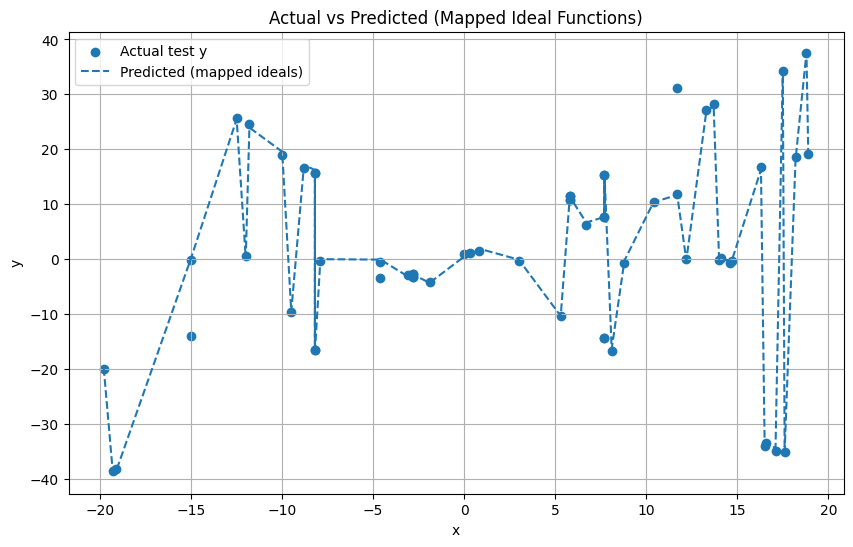

In [ ]:
# === Cell: Actual vs Predicted line plot (place after you create test_mapped) ===
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load data
conn = sqlite3.connect("results.db")  # or "results (1).db" if that's your file
test_raw = pd.read_sql("SELECT * FROM test_raw;", conn)
test_mapped = pd.read_sql("SELECT * FROM test_mapped;", conn)
ideal = pd.read_sql("SELECT * FROM ideal_functions;", conn)
conn.close()

# 2) Ensure column names are exactly as used below. If different, rename here.
# Example:
# test_mapped columns expected: "X (test)", "Y (test)", "Delta Y (test)", "No. of ideal func"
# ideal columns expected: "x", "y1"..."y50"

# 3) Merge test_mapped with ideal on x to fetch the right ideal column value
merged = test_mapped.merge(ideal, left_on="X (test)", right_on="x", how="left")

# 4) Build predicted y from the chosen ideal function column
def pick_pred(row):
    try:
        col = f"y{int(row['No. of ideal func'])}"  # <- fix: cast 41.0 -> 41, then y41
        return row[col]
    except KeyError:
        return np.nan

merged["y_pred"] = merged.apply(pick_pred, axis=1)

# 5) If some X(test) values don’t exactly exist in ideal['x'], interpolate as a fallback
if merged["y_pred"].isna().any():
    # Interpolate per row using the chosen ideal function’s curve
    x_grid = ideal["x"].values
    def interp_pred(row):
        col = f"y{int(row['No. of ideal func'])}"
        if col in ideal.columns:
            return np.interp(row["X (test)"], x_grid, ideal[col].values)
        return np.nan
    merged.loc[merged["y_pred"].isna(), "y_pred"] = merged[merged["y_pred"].isna()].apply(interp_pred, axis=1)

# 6) Join in the actual test_raw y to ensure same order (optional)
merged = merged.merge(test_raw.rename(columns={"x":"x_test","y":"y_actual"}),
                      left_on="X (test)", right_on="x_test", how="left")

# 7) Plot: actual vs predicted across x
plt.figure(figsize=(10,6))
plt.scatter(merged["X (test)"], merged["y_actual"], label="Actual test y")   # points
plt.plot(merged.sort_values("X (test)")["X (test)"],
         merged.sort_values("X (test)")["y_pred"],
         linestyle="--", label="Predicted (mapped ideals)")                   # line
plt.xlabel("x")
plt.ylabel("y")
plt.title("Actual vs Predicted (Mapped Ideal Functions)")
plt.grid(True)
plt.legend()
plt.show()


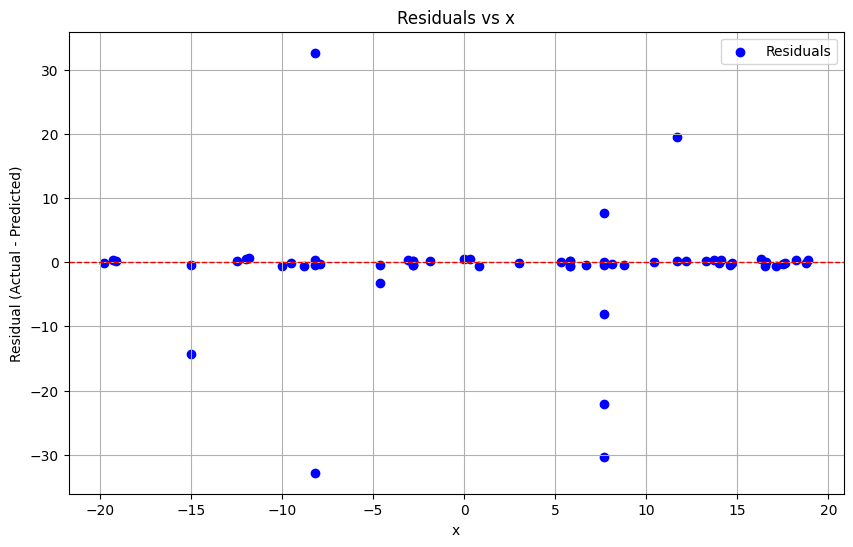

In [ ]:
# === Cell: Single Residual Plot (use in Section 2.3) ===
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

db_path = "results.db"  # change if your file is "results (1).db"

# 1) Load tables
with sqlite3.connect(db_path) as conn:
    test_raw = pd.read_sql("SELECT * FROM test_raw;", conn)
    test_mapped = pd.read_sql("SELECT * FROM test_mapped;", conn)
    ideal = pd.read_sql("SELECT * FROM ideal_functions;", conn)

# 2) Merge and get predictions
merged = test_mapped.merge(ideal, left_on="X (test)", right_on="x", how="left")

def get_pred(row):
    col = f"y{int(row['No. of ideal func'])}"
    if col in ideal.columns:
        return np.interp(row["X (test)"], ideal["x"].values, ideal[col].values)
    return np.nan

merged["y_pred"] = merged.apply(get_pred, axis=1)
merged = merged.merge(test_raw.rename(columns={"x":"x_test","y":"y_actual"}),
                      left_on="X (test)", right_on="x_test", how="left")

# 3) Residuals
merged["residual"] = merged["y_actual"] - merged["y_pred"]

# 4) Plot residuals vs x
plt.figure(figsize=(10,6))
plt.scatter(merged["X (test)"], merged["residual"], color="blue", label="Residuals")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("x")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs x")
plt.legend()
plt.grid(True)
plt.show()



## 5) Visualization (Bokeh): Training vs Chosen Ideals + Test Mapping


In [ ]:

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool

output_notebook()

p = figure(title="Training vs Chosen Ideals + Test Mapping",
           width=900, height=500,
           x_axis_label="x", y_axis_label="y",
           tools="pan,wheel_zoom,box_zoom,reset,save,hover")

src_x = train_df["x"]

# plot training y1..y4
for yk in ["y1","y2","y3","y4"]:
    p.line(src_x, train_df[yk], legend_label=f"train {yk}")

# plot chosen ideals
for yk in ["y1","y2","y3","y4"]:
    ym = best_map[yk]
    p.line(src_x, ideal_df[ym], line_dash="dashed", legend_label=f"ideal {ym}")

# mark mapped/unmapped test points
test_df = test_df.copy()
key_m = set((x,y) for x,y in zip(mapped_df["X (test)"], mapped_df["Y (test)"])) if not mapped_df.empty else set()
test_df["_mapped"] = test_df.apply(lambda r: (r["x"], r["y"]) in key_m, axis=1)

mapped_points = test_df[test_df["_mapped"]].rename(columns={"x":"x_t","y":"y_t"})
unmapped_points = test_df[~test_df["_mapped"]].rename(columns={"x":"x_t","y":"y_t"})

src_m = ColumnDataSource(mapped_points)
src_u = ColumnDataSource(unmapped_points)

p.circle(x="x_t", y="y_t", size=7, source=src_m, legend_label="test mapped")
p.circle(x="x_t", y="y_t", size=7, source=src_u, legend_label="test unmapped")

p.add_tools(HoverTool(tooltips=[("x","@x_t"),("y","@y_t")]))
p.legend.location = "top_left"

show(p)



## 6) Unit Tests


In [ ]:

import unittest

class TestOOPPipeline(unittest.TestCase):
    def test_training_schema(self):
        self.assertEqual(list(train_df.columns), ["x","y1","y2","y3","y4"])
    def test_ideal_schema(self):
        self.assertEqual(ideal_df.columns[0], "x")
        self.assertEqual(ideal_df.shape[1], 51)
    def test_test_schema(self):
        self.assertEqual(list(test_df.columns), ["x","y"])
    def test_best_map(self):
        self.assertEqual(set(best_map.keys()), {"y1","y2","y3","y4"})
        for col in best_map.values():
            self.assertTrue(col.startswith("y") and 1 <= int(col[1:]) <= 50)
    def test_thresholds(self):
        for v in thresholds.values():
            self.assertGreaterEqual(v, 0.0)
    def test_mapped_columns(self):
        if not mapped_df.empty:
            self.assertEqual(
                list(mapped_df.columns),
                ["X (test)", "Y (test)", "Delta Y (test)", "No. of ideal func"]
            )
        else:
            # If no rows mapped, still ensure columns are correct on an empty frame
            self.assertEqual(
                list(mapped_df.columns),
                ["X (test)", "Y (test)", "Delta Y (test)", "No. of ideal func"]
            )

suite = unittest.TestLoader().loadTestsFromTestCase(TestOOPPipeline)
unittest.TextTestRunner(verbosity=2).run(suite)


test_best_map (__main__.TestOOPPipeline.test_best_map) ... ok
test_ideal_schema (__main__.TestOOPPipeline.test_ideal_schema) ... ok
test_mapped_columns (__main__.TestOOPPipeline.test_mapped_columns) ... ok
test_test_schema (__main__.TestOOPPipeline.test_test_schema) ... FAIL
test_thresholds (__main__.TestOOPPipeline.test_thresholds) ... ok
test_training_schema (__main__.TestOOPPipeline.test_training_schema) ... ok

FAIL: test_test_schema (__main__.TestOOPPipeline.test_test_schema)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipython-input-2498819651.py", line 10, in test_test_schema
    self.assertEqual(list(test_df.columns), ["x","y"])
AssertionError: Lists differ: ['x', 'y', '_mapped'] != ['x', 'y']

First list contains 1 additional elements.
First extra element 2:
'_mapped'

- ['x', 'y', '_mapped']
+ ['x', 'y']

----------------------------------------------------------------------
Ran 6 tests in 0.009s

FAILE

<unittest.runner.TextTestResult run=6 errors=0 failures=1>


## 7) Git link

git clone https://github.com/PanchamiVaradaraju/DLMDSPWP01-Programming-with-Python.git
cd DLMDSPWP01-Programming-with-Python



## 8) Database Result

In [ ]:
import sqlite3
import pandas as pd

# Connect
conn = sqlite3.connect("results.db")

# Read training_data
df_training = pd.read_sql("SELECT * FROM training_data;", conn)
print(df_training.head())

# Read ideal_functions
df_ideal = pd.read_sql("SELECT * FROM ideal_functions;", conn)
print(df_ideal.head())

# Read test_raw
df_test_raw = pd.read_sql("SELECT * FROM test_raw;", conn)
print(df_test_raw.head())

# Read test_mapped
df_test_mapped = pd.read_sql("SELECT * FROM test_mapped;", conn)
print(df_test_mapped.head())

conn.close()


      x         y1         y2         y3        y4
0 -20.0  39.778572 -40.078590 -20.214268 -0.324914
1 -19.9  39.604813 -39.784000 -20.070950 -0.058820
2 -19.8  40.099070 -40.018845 -19.906782 -0.451830
3 -19.7  40.151100 -39.518402 -19.389118 -0.612044
4 -19.6  39.795662 -39.360065 -19.815890 -0.306076
      x        y1        y2        y3        y4        y5        y6        y7  \
0 -20.0 -0.912945  0.408082  9.087055  5.408082 -9.087055  0.912945 -0.839071   
1 -19.9 -0.867644  0.497186  9.132356  5.497186 -9.132356  0.867644 -0.865213   
2 -19.8 -0.813674  0.581322  9.186326  5.581322 -9.186326  0.813674 -0.889191   
3 -19.7 -0.751573  0.659649  9.248426  5.659649 -9.248426  0.751573 -0.910947   
4 -19.6 -0.681964  0.731386  9.318036  5.731386 -9.318036  0.681964 -0.930426   

         y8        y9  ...        y41        y42       y43       y44  \
0 -0.850919  0.816164  ... -40.456474  40.204040  2.995732 -0.008333   
1  0.168518  0.994372  ... -40.233820  40.048590  2.990720 -0.0


## 9) To see the result we can check with SQLite DB


In [ ]:

from google.colab import files
files.download("/content/results.db")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>